In [40]:
# Import necessary libraries
import logging
logging.getLogger("prophet.plot").disabled = True
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
#from tbats import TBATS
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [41]:
# Helper function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} - MAE: {mae:.3f}, RMSE: {rmse:.3f}")
    return mae, rmse

In [26]:
# Function for ARIMA
def arima_forecast(data, periods=15):
    model = ARIMA(data, order=(2, 1, 2))  # Example order; adjust based on dataset
    fitted = model.fit()
    print("=============ARIMA===============")
    print(fitted.summary().tables[1])
    forecast = fitted.forecast(steps=periods)
    return forecast

In [51]:
# Function for SARIMA
def sarima_forecast(data, periods=15):
    model = SARIMAX(data, #endog=data['cpu used'], exog=data[['cpu requested', 'pods']],  # Example external regressors
                    order=(1, 1, 1), 
                    seasonal_order=(0, 1, 1, 7), 
                    enforce_invertibility=False
                    )
    fitted = model.fit(disp=False)
    print("=============SARIMA===============")
    print(fitted.summary().tables[1])
    forecast = fitted.forecast(steps=periods)
    return forecast

In [28]:
# Function for ETS
def ets_forecast(data, periods=15):
    model = ExponentialSmoothing(data, seasonal='add', trend='add', seasonal_periods=12)
    fitted = model.fit()
    print("=============ETS===============")
    print(fitted.summary().tables[1])
    forecast = fitted.forecast(steps=periods)
    return forecast

In [29]:
# Function for Prophet
def prophet_forecast(data, periods=15):
    df = data.reset_index().rename(columns={"date": "ds", "cpu used": "y"})
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    print("=============prophet===============")
    model.plot_components(forecast)
    return forecast['yhat'][-15:]

In [ ]:
# Function for TBATS
# def tbats_forecast(data):
#     estimator = TBATS()
#     model = estimator.fit(data)
#     forecast = model.forecast(steps=15)
#     return forecast

In [30]:
# Function to handle new namespaces
def handle_new_namespace(data, namespace, steps=15):
    """
    Handles forecasting for a new namespace with no historical data.
    Falls back to baseline models such as mean-based forecasting.

    Args:
        data (pd.DataFrame): The dataset with available namespaces.
        namespace (str): The new namespace to handle.
        steps (int): Number of future steps to forecast.

    Returns:
        np.array: Forecasted values.
    """
    # Check if the namespace exists
    if namespace not in data["namespace"].unique():
        print(f"New namespace detected: {namespace}. No historical data available.")
        
        # Fallback to mean-based forecast
        mean_usage = data["cpu used"].mean()
        print(f"Using mean-based forecast: {mean_usage:.2f}")
        forecast = np.full(steps, mean_usage)  # Repeat mean value for the forecast horizon
    else:
        print(f"Historical data found for namespace: {namespace}.")
        
        # Extract historical data for the namespace
        namespace_data = data[data["namespace"] == namespace]["cpu used"]
        forecast = ets_forecast(namespace_data, steps=steps)  # Example: Use ETS
    
    return forecast

In [31]:
# Visualization function
def plot_seaborn(data):
    sns.set_theme(style="whitegrid")
    
    # Line plot to compare CPU requested vs. used
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=data, x="date", y="cpu used", label="CPU Used", color="orange")
    plt.title("CPU Used Over Time")
    plt.legend()
    plt.show()
    
    # Boxplot to visualize variability by namespace
    plt.figure(figsize=(14, 6))
    sns.boxplot(x="namespace", y="cpu used", hue="namespace", data=data, palette="Set3", legend=False)
    plt.title("CPU Usage by Namespace")
    plt.show()
    
    # Histogram of CPU usage
    sns.histplot(data["cpu used"], kde=True, color="green")
    plt.title("Distribution of CPU Usage")
    plt.show()

In [39]:
# Plot Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
def plot_acf_pacf(data):
    time_series = data['cpu used']
    
    # Plot ACF and PACF
    plt.figure(figsize=(10, 6))
    
    # ACF Plot
    plt.subplot(211)
    plot_acf(time_series, lags=3, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')
    
    # PACF Plot
    plt.subplot(212)
    plot_pacf(time_series, lags=3, ax=plt.gca(), method='ywm')  # 'ywm' is a recommended method for PACF
    plt.title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()

In [44]:

# Main function to orchestrate the process
def main():
    # Load the dataset
    data = pd.read_csv("test-1_cpu_usage_data.csv")
    data["date"] = pd.to_datetime(data["date"], format="%d-%m-%Y")
    
    # Drop unnecessary columns
    data = data.drop(columns=["pods", "percentage of usage", "cpu requested"], errors="ignore")
    
    # Filter relevant columns
    data = data[["date", "namespace", "cpu used"]]
    
    # Set the date as the index
    data.set_index("date", inplace=True)
    
    # For daily frequency
    data = data.asfreq('D')
    
    # Process data for each namespace
    namespaces = data["namespace"].unique()
    best_algorithm = {}
    
    for namespace in namespaces:
        print(f"\nProcessing namespace: {namespace}")
        namespace_data = data[data["namespace"] == namespace]["cpu used"]

        # Forecast using different algorithms
        forecasts = {
            "ARIMA": arima_forecast(namespace_data),
            "SARIMA": sarima_forecast(namespace_data),
            "ETS": ets_forecast(namespace_data),
            "Prophet": prophet_forecast(namespace_data)
            # "TBATS": tbats_forecast(namespace_data),
            # "LSTM": lstm_forecast(namespace_data)
        }
        
        # Evaluate models
        print(f"Evaluation Results for namespace: {namespace}")
        rmse_list = []
        for model, forecast in forecasts.items():
            mae, rmse = evaluate_model(namespace_data[-15:], forecast, model)
            rmse_list.append((model, rmse))
        
        best_algo = min(rmse_list, key = lambda x: x[1])[0]
        
        best_algorithm[namespace] = best_algo
    
    print("Best Algorithm for each namespace: ")
    for namespace, algorithm in best_algorithm.items():
        print(f"{namespace}: {algorithm}")
    
    # Visualization
    plot_seaborn(data)
    
    # ACF & PACF
    plot_acf_pacf(data)


Processing namespace: test-1
=============ARIMA===============
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4859      0.375      1.297      0.195      -0.248       1.220
ar.L2         -0.2153      0.087     -2.474      0.013      -0.386      -0.045
ma.L1         -1.3848      0.374     -3.704      0.000      -2.118      -0.652
ma.L2          0.3863      0.376      1.027      0.305      -0.351       1.124
sigma2      3884.2209    678.360      5.726      0.000    2554.659    5213.783


c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
11:38:00 - cmdstanpy - INFO - Chain [1] start processing
11:38:00 - cmdstanpy - INFO - Chain [1] done processing


=============SARIMA===============
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0033      0.080     -0.041      0.967      -0.160       0.153
ma.L1         -0.9555      0.047    -20.203      0.000      -1.048      -0.863
ma.S.L7       -1.0754      0.088    -12.197      0.000      -1.248      -0.903
sigma2      3059.3853    562.765      5.436      0.000    1956.386    4162.385
=============ETS===============
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0184882                alpha                 True
smoothing_trend               0.0181569                 beta                 True
smoothing_seasonal            0.0821749                gamma                 True
initial_level                 135.74808          

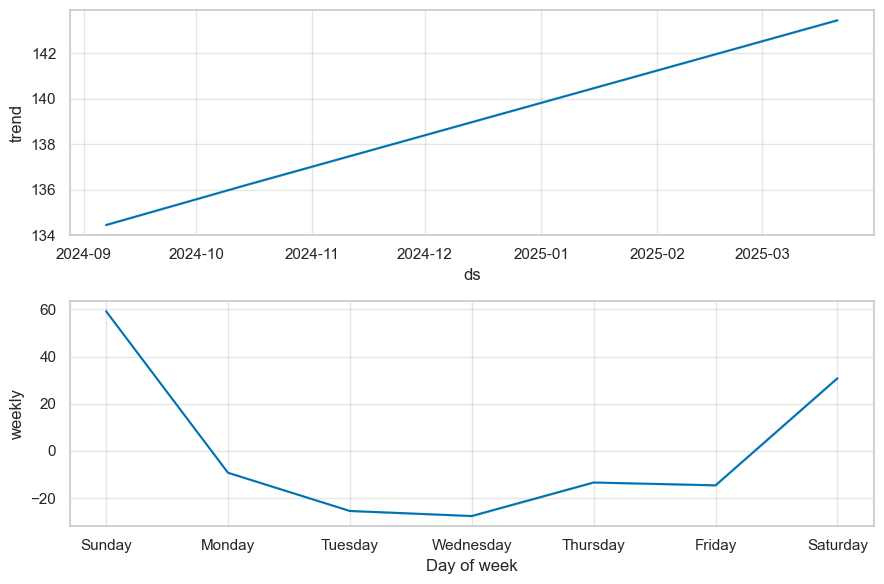

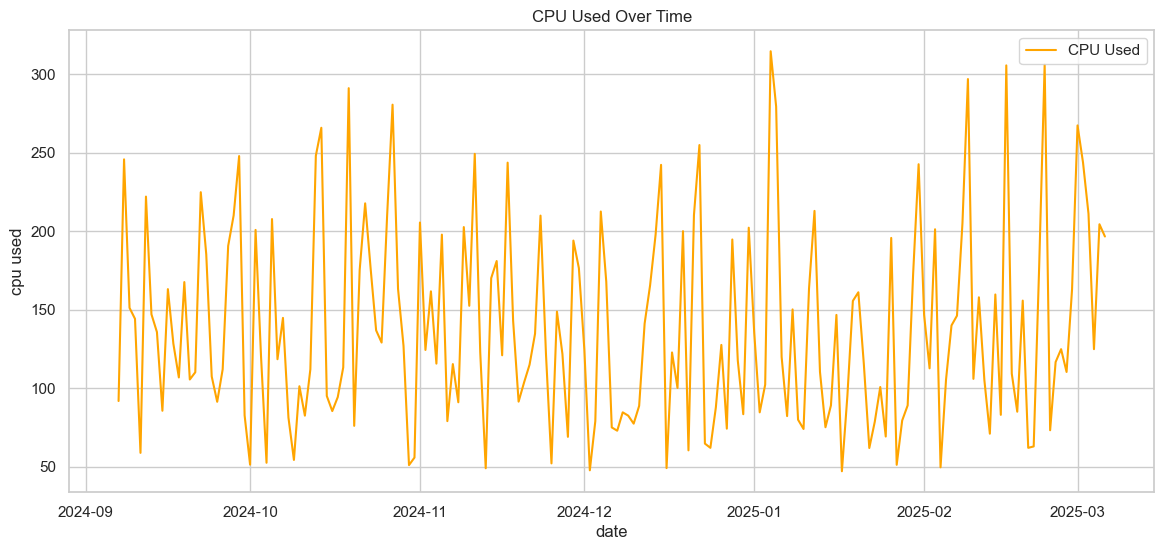

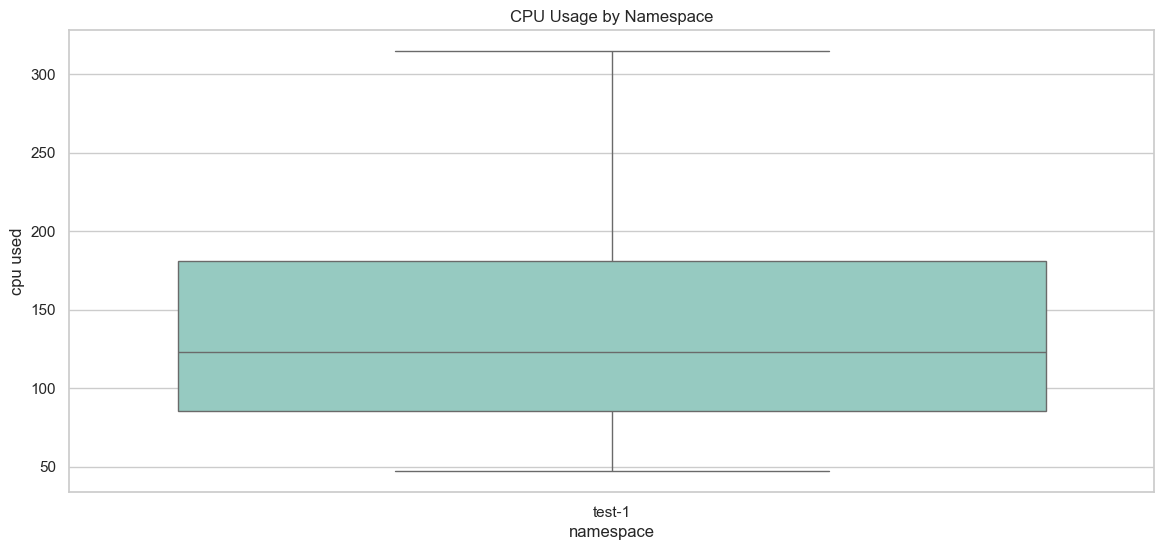

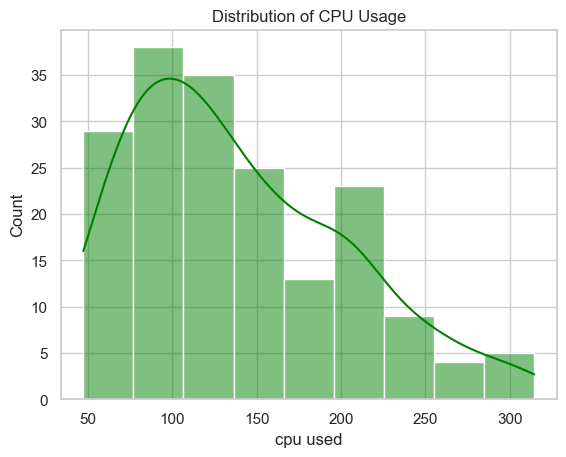

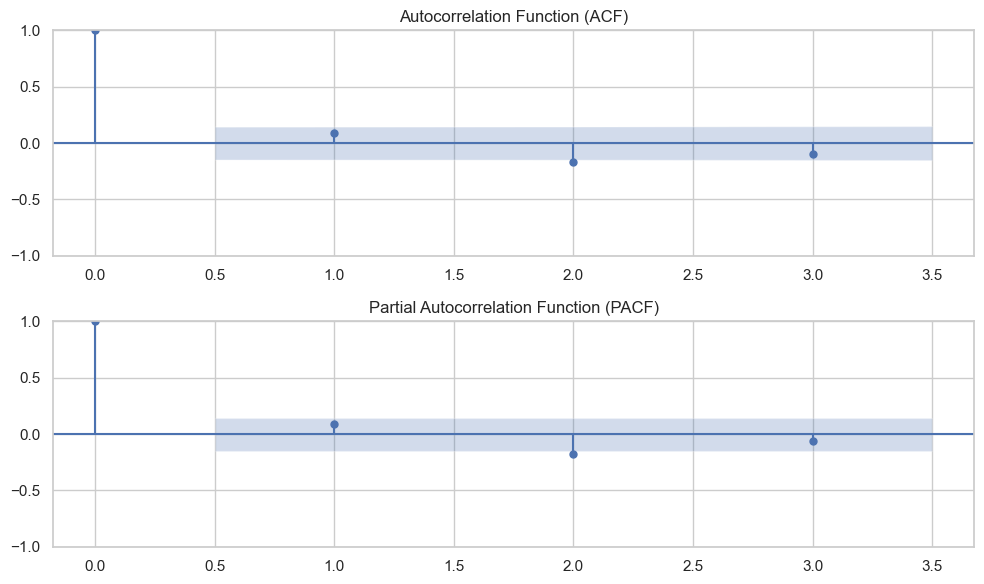

In [52]:
if __name__ == "__main__":
    main()

### Key Changes and Details

1. Column Filtering:

    * The unnecessary columns pods, percentage of usage, and cpu_requested are dropped, keeping only date, namespace, and cpu_used.

2. Namespace Handling:

    * The code processes data separately for each namespace and evaluates the performance of all six algorithms.

3. Visualization:

    * A line plot for cpu_used, a boxplot of CPU usage by namespace, and a histogram of CPU usage distribution.

4. Evaluation Metrics:

    * Each model is evaluated using MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error).

5. Forecasting Algorithms:

    * The forecasting methods are called in sequence for each namespace.

### 1. ARIMA Parameter Adjustment
ARIMA requires three parameters: (p, d, q):

* p: The number of lag observations in the model (AR term).
* d: The degree of differencing needed to make the series stationary.
* q: The size of the moving average window (MA term).

### Suggested Steps:
* Make the series stationary: CPU usage might not be stationary due to seasonality or trends. Apply differencing (d) until the series becomes stationary.

    * For example, in your sample dataset, d=1 is a good starting point because there might be a single trend component to remove.

* Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots:

    * Use the ACF plot to estimate q (the lag in moving average).
    * Use the PACF plot to estimate p (the lag in the autoregressive model).

### For your sample dataset:

* Based on a typical analysis of similar data, start with ARIMA (2, 1, 2)

### 2. SARIMA Parameter Adjustment
SARIMA extends ARIMA to include seasonality with parameters (P, D, Q, s):

* P: Seasonal autoregressive order.
* D: Seasonal differencing order.
* Q: Seasonal moving average order.
* s: Seasonality period (e.g., 12 for monthly seasonality or 7 for weekly).

### Suggested Steps:
* Identify the seasonal component (s) by observing the periodicity in your data. For example, if the dataset has daily CPU usage patterns, and there's a weekly cycle, set s=7.

* Seasonal differencing (D) removes seasonality from the series. Start with D=1 for this dataset.

* Estimate P and Q using the seasonal PACF and ACF plots.

### For your sample dataset:

* Start with SARIMA (1, 1, 1)(1, 1, 1, 7)

### Fine-Tuning:

1. Grid Search: Use grid search to optimize (p, d, q) and (P, D, Q, s) by testing a range of values and evaluating the performance metrics (e.g., MAE, RMSE).

    # Example Grid Search
    import itertools \
    p = d = q = range(0, 3) \
    seasonal_pdq = [(x[0], x[1], x[2], 7) for x in itertools.product(p, d, q)]


2. Diagnostics: After fitting the model, check residuals to ensure that they are white noise.